# Quadratic unconstrained binary optimization (QUBO)

## Example 1

Consider a set of N positive integers (though one doesn't need to) $U = \{n_1, n_2, n_3, \dots, n_N\}$, and imagine the goal is to construct two disjoint subsets of this, called A and B, such that $A\cup B=U$ and $A\cap B=\empty$, such that the sum of the numbers in each subset is equal or as close to each other as possible.

Formally, the sets A and B are to be constructed so that

$$f(\{n_i\}) = (S_A - S_B)^2~~\text{where}$$
$$S_A = \sum_{i\in A} n_i, \quad S_B = \sum_{i\in B}n_i$$

is minimum. This is a `cost function` that has to be minimized.

What we do is, assign to each number $n_i$ a binary variable $x_i$, such that $x_i = 1$ if $n_i\in A$ or otherwise $x_i = 0$ if $n_i \in B$.

Now we can write the partial sum as
$$
S_A = \sum_{i\in U} n_i x_i \\S_B = \sum_{i\in U}n_i (1-x_i)
$$

The cost function can now be written as 

\begin{align}
f(\{n_i\}) &= (S_A - S_B)^2 = S_A^2 + S_B^2 - 2S_A S_B\\
&= (\sum_{i\in U} n_i x_i)^2 + (\sum_{i\in U}n_i (1-x_i))^2 - 2 (\sum_{i\in U} n_i x_i)\sum_{j\in U}n_j (1-x_j)\\
&= \sum_{ij\in U}\left[
    n_i n_j x_i x_j + n_i n_j (1-x_i)(1-x_j) - 2 n_i n_j x_i (1-x_j)
    \right]\\
    &= \sum_{ij\in U} n_i n_j (x_i x_j + 1 - x_i - x_j + x_i x_j - 2x_i + 2 x_i x_j)\\
    &= 4\sum_{ij\in U} n_i n_j x_i x_j - 4\sum_{ij\in U}(n_i n_j x_i) + S^2\\
    &= 4\sum_{ij\in U} n_i n_j x_i x_j - 4S\sum_{i\in U}n_i x_i + S^2 
\end{align}

Where $S_U = \sum_{i\in U} n_i$ is the sum of all the numbers in the set U. Thus we need to minimize the `f` over the discrete space of vector **x** $ = \{x_1, x_2, \dots, x_N\}$. Note that the cost function `f` is quadratic in $x_i$

$$
f(x) = 4\sum_{ij\in U} n_i n_j x_i x_j - 4S\sum_{i\in U}n_i x_i + S^2 
$$


The cost function can be expressed in matrix form as

$$
f(x) = 4 x^{T}Qx + V^{T}x + S^2
$$

where $Q_{ij} = 4n_i n_j$ and $V_i = -4S n_i$

\begin{align}
f(\{n_i\}) = 4\sum_{ij\in U} n_i n_j x_i x_j - 4S\sum_{i\in U}n_i x_i + S^2
\\
= 8\sum_{i>j} n_i n_j x_i x_j
+4\sum_{i}(n_i^2 - S n_i) x_i + S^2 
\end{align}




# Package dependency

We need the `dwave` SDK for the optimizations to test or run the codes.

In your virtual environment, install the following -
```bash
pip install dwave-system
```

In [23]:
from typing import Any
import numpy as np
import itertools
import matplotlib.pyplot as plt


class qubo:

    def __init__(self, ni: np.ndarray) -> None:
        self.ni = np.asarray(ni)
        self.Q = 4 * np.outer(self.ni, self.ni)
        self.S = self.ni.sum()
        self.V = -4 * self.S * self.ni
        self.N = self.ni.shape[0]
    def __call__(self, x: Any) -> float:
        f = x @ (self.Q @ x) + self.V.dot(x) + self.S**2
        return f

def heuristic_solve(numlist):
    import copy
    N = len(numlist)
    list_copy = copy.deepcopy(list(numlist))
    list_copy.sort()
    set_AB = ([], [])
    ii, cc = 0, 0
    for i in range(N//2):
        x, y = list_copy.pop(0), list_copy.pop(-1)
        set_AB[ii].extend((x, y))
        ii = 1 - ii
        cc += 1
    n = len(list_copy)
    if n == 1:
        set_AB[1].append(list_copy.pop())
    elif n == 2:
        if cc%2 == 0:
            x, y = list_copy
            set_AB[ii].append(y)
            set_AB[1-ii].append(x)
        else:
            x, y = list_copy.pop(), list_copy.pop()
            set_AB[ii].extend((x, y))
    y1, y2 = set_AB
    x = np.asarray([i in y1 for i in numlist])
    # fix this!
    return x, y1, y2



# Plotting the distribution

Here we plot the distribution of the cost function $f(x)$. We generate all possible ways we can divide the set into two subsets, which gives us binary vector ${x}$, and corresponding value of the cost function $f(x)$. We plot the historgram of $f(x)$.

To count the numbers, first we group ways into cardinality of subsets A and B. 

- If set A has 1 element, and B the rest $N-1$ elements, there are $N$ or ${}^NC_1$ ways to construct A and B.
- If set A has 2 elements, and B the rest $N-2$ elements, there are $N(N-1)/2$ or ${}^NC_2$ ways to construct A and B.
- If set A has 3 elements, and B the rest $N-3$ elements, there are ${}^NC_3$ ways to construct A and B.
- This can go on, until A has $\frac N2$ elements, and B remaining, and there are ${}^NC_{\frac N2}$ ways to construct A, and B.

The total number, to construct A and B, and corresponding number of $x$ vectors is

$$
N_{vec} = {}^NC_1 + {}^NC_2 + {}^NC_3 \dots {}^NC_{\frac{N}{2}} = 2^{N-1}
$$



In [33]:
# a = np.random.random(6) * 10 + 1
a = np.array([2, 5, 9, 7, 3, 5])
x = np.array([1, 1, 1, 0, 0, 0])
a = a.astype(int)
qfunc = qubo(ni=a)
a == qfunc.ni,a
A = np.array([2,5,9])
B = np.array([7,3,5])
print(qfunc(x), (A.sum()-B.sum())**2)

nsize = len(a) # the number of numbers
il = np.arange(nsize)
q_f = qfunc
vecs = [] # store the vectors
dist = [] # store the function values
for choose in range(1,nsize//2+1):
    print(f'separation: ({choose},{nsize-choose})')
    for ii in itertools.combinations(il, choose):
        xi = np.fromiter(((i in ii) for i in il), dtype=bool)
        fi = q_f(xi)
        vecs += [xi]
        dist += [fi]
        #print(ii, xi.astype(int))
vecs = np.array(vecs)
dist = np.array(dist)

1 1
separation: (1,5)
separation: (2,4)
separation: (3,3)


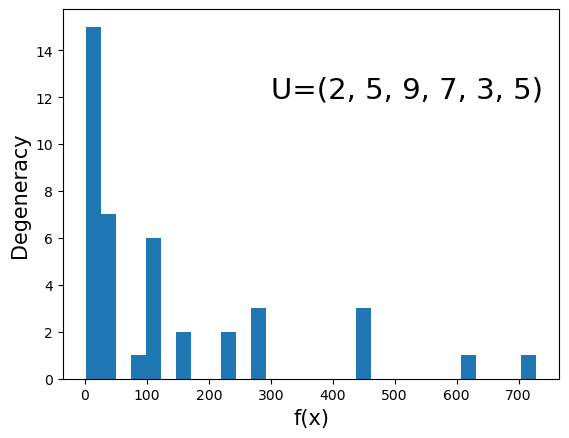

In [34]:
# Plot the distribution

#plt.xlim(0,30000)
toprint = 'U=(' + ', '.join([str(i) for i in a]) + ')'
plt.text(300, 12, toprint, fontsize=21)
plt.xlabel('f(x)', fontsize=15)
plt.ylabel('Degeneracy', fontsize=15)
dd = plt.hist(dist, bins=30)

In [35]:


# a = np.random.random(6) * 10 + 1
a = np.array([2, 5, 9, 7, 3, 5, 100])
x = np.array([1, 1, 1, 0, 0, 0, 0])
a = a.astype(int)
qfunc = qubo(ni=a)
a == qfunc.ni,a
A = np.array([2,5,9])
B = np.array([7,3,5, 100])
print(qfunc(x), (A.sum()-B.sum())**2)

nsize = len(a) # the number of numbers
il = np.arange(nsize)
q_f = qfunc
vecs = [] # store the vectors
dist = [] # store the function values
for choose in range(1,nsize//2+1):
    print(f'separation: ({choose},{nsize-choose})')
    for ii in itertools.combinations(il, choose):
        xi = np.fromiter(((i in ii) for i in il), dtype=bool)
        fi = q_f(xi)
        vecs += [xi]
        dist += [fi]
        #print(ii, xi.astype(int))
vecs = np.array(vecs)
dist = np.array(dist)

9801 9801
separation: (1,6)
separation: (2,5)
separation: (3,4)


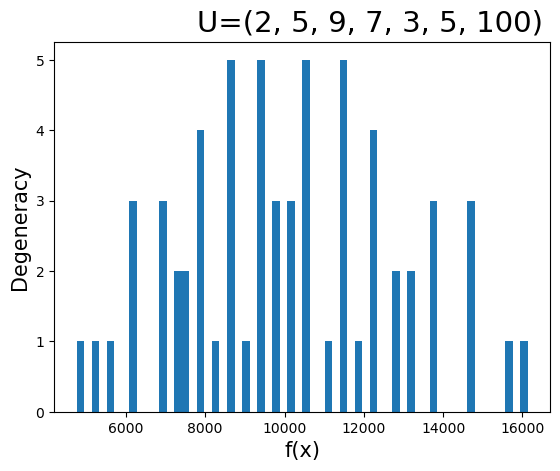

In [36]:
# Plot the distribution

#plt.xlim(0,30000)
toprint = 'U=(' + ', '.join([str(i) for i in a]) + ')'
plt.text(7800, 5.4, toprint, fontsize=21)
plt.xlabel('f(x)', fontsize=15)
plt.ylabel('Degeneracy', fontsize=15)
dd = plt.hist(dist, bins=60)

In [37]:
# Now test the distribution for a larger set size, containing uniformly distributed numbers.

nsize = 21
ni = np.random.randint(1, 30, size=nsize)
# ni = np.array([10, 1, 16, 14, 22, 26, 29, 23, 21, 5, 14, 9, 12, 27, 22, 9, 14, 27, 12, 9, 24])
# ni[-1] = 1500
il = np.arange(nsize)
q_f = qubo(ni=ni)
vecs = []
dist = []
for choose in range(1,nsize//2+1):
    print(f'separation: ({choose},{nsize-choose})')
    for ii in itertools.combinations(il, choose):
        xi = np.fromiter(((i in ii) for i in il), dtype=bool)
        fi = q_f(xi)
        vecs += [xi]
        dist += [fi]
        #print(ii, xi.astype(int))
vecs = np.array(vecs)
dist = np.array(dist)


separation: (1,20)
separation: (2,19)
separation: (3,18)
separation: (4,17)
separation: (5,16)
separation: (6,15)
separation: (7,14)
separation: (8,13)
separation: (9,12)
separation: (10,11)


U=(28, 3, 18, 17, 2, 14
8, 4, 6, 3, 16, 28
1, 13, 23, 27, 18, 6
14, 15, 1)


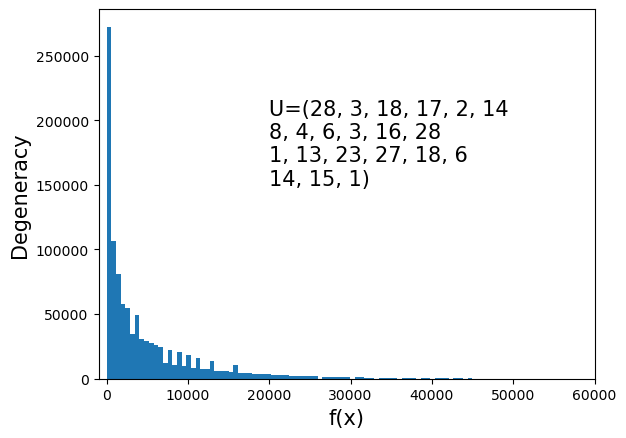

In [38]:
toprint = 'U=('
for i in range(0, ni.shape[0], 6):
    toprint += ', '.join([str(i) for i in ni[i:i+6]]) + '\n'
toprint = toprint[:-1] + ')'
print(toprint)
plt.text(20000, 150000, toprint, fontsize=15)
plt.xlabel('f(x)', fontsize=15)
plt.ylabel('Degeneracy', fontsize=15)
plt.xlim(-1000, 60000)
dd = plt.hist(dist, bins=120)

In [39]:
# We look at the large set, which is uniformly distributed, except one element that is way larger then the rest.
# We see how the distribution changes.

nsize = 21
#ni = np.random.randint(1, 30, size=nsize)
ni[-1] = 1500
il = np.arange(nsize)
q_f = qubo(ni=ni)
vecs = []
dist = []
for choose in range(1,nsize//2+1):
    print(f'separation: ({choose},{nsize-choose})')
    for ii in itertools.combinations(il, choose):
        xi = np.fromiter(((i in ii) for i in il), dtype=bool)
        fi = q_f(xi)
        vecs += [xi]
        dist += [fi]
        #print(ii, xi.astype(int))
vecs = np.array(vecs)
dist = np.array(dist)


separation: (1,20)
separation: (2,19)
separation: (3,18)
separation: (4,17)
separation: (5,16)
separation: (6,15)
separation: (7,14)
separation: (8,13)
separation: (9,12)
separation: (10,11)


U=(28, 3, 18, 17, 2, 14
8, 4, 6, 3, 16, 28
1, 13, 23, 27, 18, 6
14, 15, 1500)


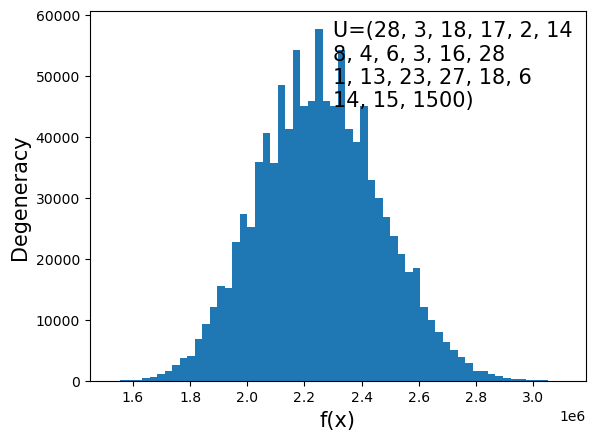

In [41]:
toprint = 'U=('
for i in range(0, ni.shape[0], 6):
    toprint += ', '.join([str(i) for i in ni[i:i+6]]) + '\n'
toprint = toprint[:-1] + ')'
print(toprint)
plt.text(2.3e6, 45000, toprint, fontsize=15)
plt.xlabel('f(x)', fontsize=15)
plt.ylabel('Degeneracy', fontsize=15)
#plt.xlim(-1000, 60000)
dd = plt.hist(dist, bins=60)

In [44]:
# In this cell one can play with the heuristic solver.
# It is very fast, but starts to give wrong answers for larger sets that are not evenly distributed.
# It's result aren't ideal even if the set's elements are evenly distributed.


# numlist = [3,4,3,6,10,7,12,8,5,6,11, 2, 3]
# numlist = [1,2,3,4,5,6,7,8, 12]
nsize = 1001
numlist = np.random.randint(0, 11, size=1001).tolist()
numlist[-1] = 100       # comment this line to keep the set uniformly distributed.

x, y1, y2 = heuristic_solve(np.array(numlist))
print(x.astype(int))
print(len(numlist), numlist)
print(len(y1), y1)
print(len(y2), y2)
print('f_n = ', (sum(y1) - sum(y2))**2)

[1 1 1 ... 1 1 1]
1001 [6, 5, 0, 7, 10, 1, 6, 0, 9, 4, 4, 5, 4, 5, 1, 8, 8, 0, 8, 3, 4, 10, 5, 0, 2, 10, 3, 6, 6, 6, 9, 3, 7, 8, 9, 4, 8, 8, 7, 0, 2, 5, 6, 8, 10, 6, 6, 9, 0, 0, 8, 2, 1, 4, 3, 2, 8, 1, 1, 9, 4, 1, 5, 3, 10, 0, 4, 7, 0, 10, 9, 3, 10, 7, 8, 4, 8, 5, 3, 3, 3, 8, 1, 4, 0, 1, 6, 10, 4, 7, 6, 5, 7, 5, 4, 6, 2, 2, 4, 9, 0, 1, 10, 3, 5, 1, 2, 4, 9, 3, 4, 7, 4, 7, 6, 6, 5, 0, 8, 9, 3, 5, 4, 6, 2, 0, 3, 7, 9, 10, 3, 0, 7, 6, 9, 5, 0, 1, 10, 7, 6, 5, 2, 3, 9, 7, 8, 8, 8, 8, 9, 6, 2, 0, 7, 2, 7, 2, 2, 7, 8, 9, 7, 0, 2, 2, 6, 6, 5, 4, 5, 1, 6, 2, 2, 0, 6, 5, 10, 9, 1, 9, 6, 5, 9, 3, 4, 2, 0, 7, 2, 6, 3, 7, 8, 3, 10, 1, 4, 4, 4, 2, 10, 1, 10, 6, 4, 5, 0, 6, 0, 6, 2, 2, 2, 9, 2, 6, 3, 3, 4, 3, 1, 5, 3, 3, 8, 1, 3, 4, 4, 6, 3, 7, 8, 9, 6, 2, 2, 6, 7, 4, 9, 7, 3, 9, 7, 3, 5, 4, 1, 2, 1, 7, 3, 3, 3, 9, 6, 8, 1, 9, 8, 6, 8, 7, 5, 4, 7, 5, 9, 2, 9, 9, 9, 6, 10, 3, 0, 4, 5, 7, 9, 8, 1, 7, 1, 10, 1, 9, 6, 5, 0, 6, 0, 8, 10, 8, 4, 1, 7, 10, 4, 9, 0, 6, 3, 2, 3, 7, 6, 6, 0, 8, 7, 8, 10, 4, 7,

In [46]:
import dimod

# First initialize our own class qubo


# ni = np.array([3, 4, 5, 6, 8, 12, 11, 15])
# ni = np.array([1,2,3,4,5,6,7,8])

# Define the set
ni = np.random.randint(0, 31, size=60)
ni[-1] = int(ni.mean()*15)

qubofunc = qubo(ni=ni)     # initialise the function.

# extract the quadratic term as dictionary
qdict = {(i, j): 2*qubofunc.Q[i, j] for i in range(qubofunc.N) for j in range(qubofunc.N) if i>j}

# extract the linear term as dictionary
ldict = {i: qubofunc.V[i]+qubofunc.Q[i, i] for i in range(qubofunc.N)}
# the constant
constant = qubofunc.S**2

print(qdict)
print(ldict)
print(constant)


{(1, 0): 464, (2, 0): 2320, (2, 1): 160, (3, 0): 3248, (3, 1): 224, (3, 2): 1120, (4, 0): 4408, (4, 1): 304, (4, 2): 1520, (4, 3): 2128, (5, 0): 3248, (5, 1): 224, (5, 2): 1120, (5, 3): 1568, (5, 4): 2128, (6, 0): 6264, (6, 1): 432, (6, 2): 2160, (6, 3): 3024, (6, 4): 4104, (6, 5): 3024, (7, 0): 3944, (7, 1): 272, (7, 2): 1360, (7, 3): 1904, (7, 4): 2584, (7, 5): 1904, (7, 6): 3672, (8, 0): 5336, (8, 1): 368, (8, 2): 1840, (8, 3): 2576, (8, 4): 3496, (8, 5): 2576, (8, 6): 4968, (8, 7): 3128, (9, 0): 2320, (9, 1): 160, (9, 2): 800, (9, 3): 1120, (9, 4): 1520, (9, 5): 1120, (9, 6): 2160, (9, 7): 1360, (9, 8): 1840, (10, 0): 0, (10, 1): 0, (10, 2): 0, (10, 3): 0, (10, 4): 0, (10, 5): 0, (10, 6): 0, (10, 7): 0, (10, 8): 0, (10, 9): 0, (11, 0): 5800, (11, 1): 400, (11, 2): 2000, (11, 3): 2800, (11, 4): 3800, (11, 5): 2800, (11, 6): 5400, (11, 7): 3400, (11, 8): 4600, (11, 9): 2000, (11, 10): 0, (12, 0): 1160, (12, 1): 80, (12, 2): 400, (12, 3): 560, (12, 4): 760, (12, 5): 560, (12, 6): 1080

In [48]:
# We pass the quadratic, linear and constant term to the BinaryQuadraticModel class of the dimod module.
bqm_set = dimod.BinaryQuadraticModel(ldict, qdict, offset=constant, vartype=dimod.BINARY)

print(bqm_set.quadratic == qdict)
print(bqm_set.linear == ldict)

# Samplers are solvers that provide us with optimized samples of the variable 'x'
# with optimal cost function value.

# sampler = dimod.ExactSolver() # this is exact solver, that searches minima with brute force.

sampler = dimod.samplers.SimulatedAnnealingSampler() # this uses Monte-Carlo based Annealing to get minima.
sample_set = sampler.sample(bqm_set, num_sweeps=1000)
sample_set = sample_set.truncate(15)

for sample in sample_set.samples():
    xi = sample._data.astype(int)
    fi = qubofunc(xi)
    ia = [k for k, v in sample.items() if v == 0]
    ib = [k for k, v in sample.items() if v == 1]
    print(f"x = {xi}, f(x)={fi}, set A = {ni[ia]}, set B = {ni[ib]}")
print(ni)



True
True
x = [1 0 1 1 1 1 1 1 0 0 1 0 1 1 1 0 0 1 0 0 1 1 1 0 0 1 1 0 0 1 0 1 1 1 1 1 0
 0 0 1 1 0 0 1 1 0 1 0 0 1 0 1 0 1 0 0 1 1 1 0], f(x)=1, set A = [  2  23  10  25   5  13  10   5   5   8   4  21  18  30  26   3  11  14
  20   6   5  24   2  17   1 207], set B = [29 10 14 19 14 27 17  0  5 14 13 19  3 19  6 16  5 12 11  4 16 28 27 30
 14  8 19  5  5 19 28 21 11 26]
x = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 1 1 0
 0 0 1 1 0 1 0 0 1 0 1 0 1 0 1 1 0 1 1 1 1 1 1], f(x)=1, set A = [29  2 10 14 19 14 27 17 23 10  0 25  5 14 13  5 13 19 10 19  6 12 18 11
  4 16 30 26  3 11  8 19  5  5 24 28], set B = [  5   3   5   8  16   5   4  21  28  27  30  14  14  20   6   5  19   2
  17   1  21  11  26 207]
x = [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 0 0 0 0 1 1 0 1 0 0 1 0 0 0 1 1
 0 0 0 0 1 1 1 0 1 0 1 0 1 1 0 1 1 0 0 0 1 1 0], f(x)=1, set A = [ 13  10   5  19   6   5   8   4  12  18   4  16  28  26   3  30  14  19
   5   5  19  17   1  21 207], set B = [29  2

In [49]:
# The corresponding Heuristic solver
x, y1, y2 = heuristic_solve(ni)
print(f"Heuristic result: set A = {y1}, set B = {y2}, {(sum(y1) - sum(y2))**2}")

Heuristic result: set A = [0, 207, 2, 30, 3, 28, 4, 27, 5, 26, 5, 25, 5, 23, 5, 21, 6, 19, 8, 19, 10, 19, 10, 17, 11, 16, 12, 14, 13, 14], set B = [1, 30, 2, 29, 3, 28, 4, 27, 5, 26, 5, 24, 5, 21, 5, 20, 6, 19, 8, 19, 10, 18, 11, 17, 11, 16, 13, 14, 14, 14], 32041


In [58]:
"""
Below is ising model example.
"""

class Ising:
    """
    Here we define 1D Ising model through a python class,
    which we use in the QUBO exercise.
    """
    def __init__(self, N=10, Jij=None, h=None) -> None:
        """
        Ising class init.
        Requires N: int -> number of lattice site.
        Jij: real array of length (N-1)
        h = magnetic field, keep this none for the moment.
        """
        self.N = N
        if Jij is None:
            self.Jij = np.ones(self.N-1)
        else:
            self.Jij = Jij
        self.h = h
        self.Q = np.zeros([self.N, self.N])
        # self.Q is the matrix that encapsulates the QUBO problem.
        for i in range(self.N-1):
            self.Q[i, i+1] = Jij[i]
            self.Q[i+1, i] = Jij[i]
        if h is None:
            self.V = np.zeros(self.N)
        else:
            self.V = h * np.ones(self.N)
    #
    def __call__(self, x):
        f = 0.5 * (x.T @ self.Q) @ x + self.V @ x
        return f


N = 30         # Define the lattice size
Jey = np.ones(N-1) # Define the coupling

ising = Ising(N=N, Jij=Jey)  # Instantiate the ising class.
qdict_ising = {(i, j): 0.5 * ising.Q[i, j] for i in range(ising.N) for j in range(ising.N)}
bqm_ising = dimod.BinaryQuadraticModel(qdict_ising, vartype=dimod.SPIN)
print(bqm_ising.quadratic)

# sampler = dimod.ExactSolver()
sampler = dimod.samplers.SimulatedAnnealingSampler()
sample_set = sampler.sample(bqm_ising, num_sweeps=1000)
sample_set = sample_set.truncate(15)

print(sample_set)
for sample in sample_set.samples():
    xi = sample._data.astype(int)
    fi = ising(xi)
    print(xi, fi)

sample._data



{(1, 0): 1.0, (2, 0): 0.0, (2, 1): 1.0, (3, 0): 0.0, (3, 1): 0.0, (3, 2): 1.0, (4, 0): 0.0, (4, 1): 0.0, (4, 2): 0.0, (4, 3): 1.0, (5, 0): 0.0, (5, 1): 0.0, (5, 2): 0.0, (5, 3): 0.0, (5, 4): 1.0, (6, 0): 0.0, (6, 1): 0.0, (6, 2): 0.0, (6, 3): 0.0, (6, 4): 0.0, (6, 5): 1.0, (7, 0): 0.0, (7, 1): 0.0, (7, 2): 0.0, (7, 3): 0.0, (7, 4): 0.0, (7, 5): 0.0, (7, 6): 1.0, (8, 0): 0.0, (8, 1): 0.0, (8, 2): 0.0, (8, 3): 0.0, (8, 4): 0.0, (8, 5): 0.0, (8, 6): 0.0, (8, 7): 1.0, (9, 0): 0.0, (9, 1): 0.0, (9, 2): 0.0, (9, 3): 0.0, (9, 4): 0.0, (9, 5): 0.0, (9, 6): 0.0, (9, 7): 0.0, (9, 8): 1.0, (10, 0): 0.0, (10, 1): 0.0, (10, 2): 0.0, (10, 3): 0.0, (10, 4): 0.0, (10, 5): 0.0, (10, 6): 0.0, (10, 7): 0.0, (10, 8): 0.0, (10, 9): 1.0, (11, 0): 0.0, (11, 1): 0.0, (11, 2): 0.0, (11, 3): 0.0, (11, 4): 0.0, (11, 5): 0.0, (11, 6): 0.0, (11, 7): 0.0, (11, 8): 0.0, (11, 9): 0.0, (11, 10): 1.0, (12, 0): 0.0, (12, 1): 0.0, (12, 2): 0.0, (12, 3): 0.0, (12, 4): 0.0, (12, 5): 0.0, (12, 6): 0.0, (12, 7): 0.0, (12, 8)

array([-1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,
        1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1], dtype=int8)